# BT02: Ẩn tin mật trên ảnh gif (ảnh palette-based) bằng phương pháp LSB


Họ tên: Vũ Mạnh Hùng

MSSV: 18424029

---
## Cách làm bài và nộp bài
&#9889; Bạn lưu ý là mình sẽ dùng chương trình hỗ trợ chấm bài nên bạn cần phải tuân thủ chính xác qui định mà mình đặt ra, nếu không rõ thì hỏi, chứ không nên tự tiện làm theo ý của cá nhân.

**Cách làm bài**

Bạn sẽ làm trực tiếp trên file notebook này. Đầu tiên, bạn điền họ tên và MSSV vào phần đầu file ở bên trên. Trong file, bạn làm bài ở những chỗ có ghi là:
```python
# YOUR CODE HERE
raise NotImplementedError()
```
hoặc đối với những phần code không bắt buộc thì là:
```python
# YOUR CODE HERE (OPTION)
```
hoặc đối với markdown cell thì là:
```markdown
YOUR ANSWER HERE
```
Tất nhiên, khi làm thì bạn xóa dòng `raise NotImplementedError()` đi.
Đối những phần yêu cầu code thì thường ở ngay phía dưới sẽ có một (hoặc một số) cell chứa các bộ test để giúp bạn biết đã code đúng hay chưa; nếu chạy cell này không có lỗi gì thì có nghĩa là qua được các bộ test. Trong một số trường hợp, các bộ test có thể sẽ không đầy đủ; nghĩa là, nếu không qua được test thì là code sai, nhưng nếu qua được test thì chưa chắc đã đúng hoàn toàn.

Trong khi làm bài, bạn có thể cho in ra màn hình, tạo thêm các cell để test. Nhưng khi nộp bài thì bạn xóa các cell mà bạn tự tạo, xóa hoặc comment các câu lệnh in ra màn hình. Bạn lưu ý <font color=red>không được tự tiện xóa các cell hay sửa code của Thầy</font> (trừ những chỗ được phép sửa như đã nói ở trên).

Trong khi làm bài, thường xuyên `Ctrl + S` để lưu lại bài làm của bạn, tránh mất mát thông tin.


*Nên nhớ mục tiêu chính ở đây là <font color=green>học, học một cách chân thật</font>. Bạn có thể thảo luận ý tưởng với bạn khác, nhưng <font color=green>code và bài làm phải là của bạn, dựa trên sự hiểu thật sự của bạn</font>. <font color=red>Nếu vi phạm thì sẽ bị 0 điểm cho toàn bộ môn học.</font>*

**Cách nộp bài**

Khi chấm bài, đầu tiên mình sẽ chọn `Kernel` - `Restart Kernel & Run All Cells`, để restart và chạy tất cả các cell trong notebook của bạn; do đó, trước khi nộp bài, bạn nên chạy thử `Kernel` - `Restart Kernel & Run All Cells` để đảm bảo mọi chuyện diễn ra đúng như mong đợi.

Sau đó, bạn tạo thư mục nộp bài theo cấu trúc sau:
- Thư mục `MSSV` (vd, nếu bạn có MSSV là 1234567 thì bạn đặt tên thư mục là `1234567`)
    - Thư mục `BT02`
        - File `BT02-AnTinMatTrenAnhGif_LSB.ipynb` (không cần nộp các file khác)

Cuối cùng, bạn nén thư mục `MSSV` này lại và nộp ở link trên moodle. <font color=red>Bạn lưu ý tuân thủ chính xác cấu trúc này.</font>

---
## Import

In [10]:
from bitarray import bitarray
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import skimage.io

---
## Định nghĩa các hàm hỗ trợ (nếu cần)

In [14]:
# Lớp thông tin của các phần tử bảng màu
class ItemPalette():
    # Khai báo các thuộc tính:
    IndexPalette = -1   # Index của phần tử
    RGBPalette = np.zeros(3, dtype = np.uint8)  # Giá trị của RGB
    DistanceEuclid = 0 # Khoảng cách của phần tử đến một phần tử khác

    # Phương thức khởi tạo
    def __init__(self, _IndexPalette = -1, _RGBPalette = np.zeros(3, dtype = np.uint8), _DistanceEuclid = 0):
        self.IndexPalette = _IndexPalette
        self.RGBPalette = _RGBPalette
        self.DistanceEuclid = _DistanceEuclid

# Hàm xác định bit nhúng của pixels
def specify_bit_embed(rgb):
    if (rgb[0] + rgb[1] + rgb[2]) % 2 == 1:
        return 1
    else:
        return 0

# Hàm phân tách bảng màu thành 2 phần: Phần nhúng bit 1 và phần nhúng bit 0
# Phần nhúng bit 0 gồm những pixels có rgb sao cho (R+G+B)%2 = 0
# Phần nhúng bit 1 gồm những pixels có rgb sao cho (R+G+B)%2 = 1
def partition_palette(palette):
    lstBit0 = []
    lstBit1 = []
    for idx, rgb in enumerate(palette[0]):
        objItemPalette = ItemPalette()
        objItemPalette.IndexPalette = idx
        objItemPalette.RGBPalette = rgb        
        if specify_bit_embed(rgb) == 0:
            lstBit0.append(objItemPalette)
        else:
            lstBit1.append(objItemPalette)
    return lstBit0, lstBit1

# Hàm tính khoảng cách Euclid giữa hai numpy array
def dist_euclid(x,y):
    return np.sqrt(np.sum((x-y)**2))

# Tìm khoảng cách Euclid nhỏ nhất giữa một phần tử trong bảng màu với các phần tử khác trong bảng
# idxRGB: Chỉ số của phần tử trong bảng màu
# rgb: Giá trị RGB của phần tử
# lstBit: Danh sách các phần tử còn lại
def min_distance_euclid(idxRGB, rgb, lstBit):
    objItemPalette = ItemPalette()
    # Khởi tạo khoảng cách nhỏ nhất
    if idxRGB == 0:
        rgbX = rgb.astype(np.int)
        rgbY = lstBit[1].RGBPalette.astype(np.int)
        distMin = dist_euclid(rgbX, rgbY)
    else:
        rgbX = rgb.astype(np.int)
        rgbY = lstBit[0].RGBPalette.astype(np.int)
        distMin = dist_euclid(rgbX, rgbY)        

    # Tính khoảng cách Euclid của phần tử đến các phần tử khác => Cập nhật phần tử có khoảng cách nhỏ nhất   
    for item in lstBit:
        if idxRGB == item.IndexPalette:
            continue
        x = rgb.astype(np.int)
        y = item.RGBPalette.astype(np.int)
        dist = dist_euclid(x, y)
        if dist < distMin:
            objItemPalette.IndexPalette = item.IndexPalette
            objItemPalette.RGBPalette = item.RGBPalette
            objItemPalette.DistanceEuclid = dist
            distMin = dist

    return objItemPalette

# Hiển thị histogram của ảnh
# Nguồn: https://datacarpentry.org/image-processing/05-creating-histograms/
def show_histogram_image(imageName):
    image = skimage.io.imread(fname=imageName)

    # tuple to select colors of each channel line
    colors = ("r", "g", "b")
    channel_ids = (0, 1, 2)
    
    # create the histogram plot, with three lines, one for each color
    plt.xlim([0, 256])
    for channel_id, c in zip(channel_ids, colors):
        histogram, bin_edges = np.histogram(
            image[:, :, channel_id], bins=256, range=(0, 256)
        )
        plt.plot(bin_edges[0:-1], histogram, color=c)
    
    plt.xlabel("Giá trị màu")
    plt.ylabel("Điểm ảnh")
    plt.show()

---
## Hàm nhúng (7đ, trong đó: phần code 5đ, phần nhận xét và giải thích kết quả 2đ)

&#9889; Lưu ý:
- Khi tính toán bạn cần để ý kiểu dữ liệu. Ví dụ, nếu lấy 2 giá trị có kiểu dữ liệu `uint8` trừ cho nhau thì kết quả cũng sẽ có kiểu `uint8` và sẽ bị sai.
- Qui ước (để mình và bạn ra cùng kết quả): nếu trong bảng màu có nhiều màu thỏa điều kiện tìm kiếm thì lấy màu có chỉ số nhỏ nhất trong bảng màu. Nếu bạn có dùng hàm `sort` hay `argsort` của numpy thì bạn cần truyền tham số `kind="stable"`; nếu không thì các phần tử có giá trị giống nhau có thể sẽ bị thay đổi thứ tự tương đối với nhau trong quá trình sort.

In [5]:
def embed(msg_file, cover_img_file, stego_img_file):
    '''
    Nhúng tin mật vào ảnh gif (ảnh palette-base) bằng phương pháp của Fridrich 
    (xem file slide "06-AnTinMatTrenAnh2.pdf", trang 24).
    
    Các tham số:
        msg_file (str): Tên file chứa secret message.
        cover_img_file (str): Tên file chứa cover image.
        stego_img_file (str): Tên file chứa stego image (kết quả sau khi nhúng).
    Giá trị trả về:
        bool: True nếu nhúng thành không, False nếu không đủ chỗ để nhúng. 
    '''
    # Đọc cover img file
    cover_img = Image.open(cover_img_file)
    cover_pixels = np.array(cover_img)
    palette = cover_img.getpalette() # Kết quả là list các giá trị Red, Green, Blue của các màu 
                                     # trong bảng màu, 3 giá trị liên tiếp ứng với một màu
    palette = np.array(palette, dtype=np.uint8).reshape(1, -1, 3) # Reshape lại dưới dạng ảnh RGB
    #----------------------------------------------------------------------------------------------
    
    # Đọc file tin mật
    with open(msg_file, 'r') as f:
        msg = f.read()

    # Chuyển đổi tin mật sang dạng tin mật
    msg_bits = bitarray()
    msg_bits.fromstring(msg)    
    
    # Thêm đuôi 100.... vào
    num_bit_add =  cover_pixels.size - len(msg_bits)
    if num_bit_add > 0:
        msg_bits.append(True)                   # Thêm bit 1 vào  
        bit_add = [False] * (num_bit_add - 1) 
        msg_bits.extend(bit_add)                # Thêm  một list bit 0 vào
    else:
        return False
    #----------------------------------------------------------------------------------------------
    
    # Chia bảng màu thành 2 phần: Phần nhúng bit 1 và phần nhúng bit 0
    lst_bit_0, lst_bit_1 = partition_palette(palette)
    
    # Tiến hành nhúng bit
    idx_bit_Embed = 0
    stego_pixels = np.empty_like(cover_pixels)
    for idx, pixelsIdx in np.ndenumerate(cover_pixels):
        rgb = palette[0][pixelsIdx]
        if msg_bits[idx_bit_Embed]:
            obj = min_distance_euclid(pixelsIdx, rgb, lst_bit_1)
        else:
            obj = min_distance_euclid(pixelsIdx, rgb, lst_bit_0)
        stego_pixels[idx] = obj.IndexPalette
        idx_bit_Embed += 1
    #----------------------------------------------------------------------------------------------  
    
    # Ghi stego pixels cùng palette xuống file
    stego_img = Image.fromarray(stego_pixels)
    stego_img.putpalette(cover_img.getpalette())
    stego_img.save(stego_img_file)
    
    return True

In [6]:
# TEST 
result = embed('msg2.txt', 'lena.gif', 'lena_stego.gif')
assert result == False

In [8]:
# TEST             
result = embed('msg.txt', 'lena.gif', 'lena_stego.gif')
assert result == True
stego_img = Image.open('lena_stego.gif')
stego_pixels = np.array(stego_img)
stego_palette = stego_img.getpalette()
correct_stego_img = Image.open('correct_lena_stego.gif')
correct_stego_pixels = np.array(correct_stego_img)
correct_stego_palette = correct_stego_img.getpalette()
assert np.all(stego_pixels == correct_stego_pixels)
assert stego_palette == correct_stego_palette

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in ubyte_scalars
  app.launch_new_instance()


AssertionError: 

In [7]:
# TEST             
result = embed('msg.txt', 'baboon.gif', 'baboon_stego.gif')
assert result == True
stego_img = Image.open('lena_stego.gif')
stego_pixels = np.array(stego_img)
stego_palette = stego_img.getpalette()
correct_stego_img = Image.open('correct_lena_stego.gif')
correct_stego_pixels = np.array(correct_stego_img)
correct_stego_palette = correct_stego_img.getpalette()
assert np.all(stego_pixels == correct_stego_pixels)
assert stego_palette == correct_stego_palette

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in ubyte_scalars
  app.launch_new_instance()


AssertionError: 

Xem các ảnh và so sánh tính vô hình khi nhúng trên ảnh "lena.gif" với khi nhúng trên ảnh "baboon.gif". Theo bạn, tại sao lại như vậy? (Gợi ý: trong hàm nhúng ở trên, bạn có thể tính và cho in ra giá trị trung bình của khoảng cách từ mỗi màu trong bảng màu tới màu gần nhất mà có (R+G+B)%2 khác với (R+G+B)%2 của mình)

- Tính vô hình của ảnh baboon.gif tốt hơn của ảnh lena.gif
- Nguyên nhân:
    - Dựa vào histogram (hình bên dưới) ta thấy:  
      Ảnh "lena.gif" có phân bố màu không đều bằng ảnh "baboon.gif" nên khi thấy một pixels bằng một pixels dù gần nhất thì sự sai khác về màu sắc vẫn là rất lớn làm ảnh hưởng đến tính vô hình của ảnh sau khi nhúng

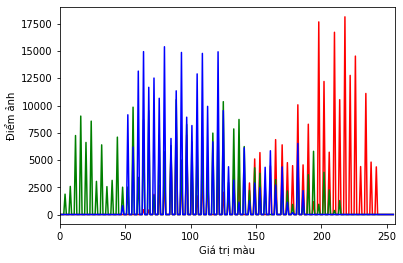

In [15]:
show_histogram_image('lena.gif')

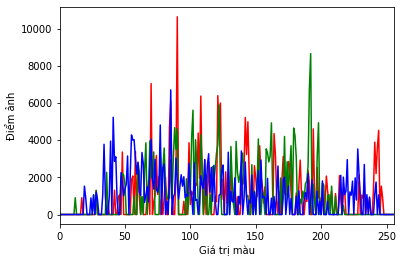

In [16]:
show_histogram_image('baboon.gif')

---
## Hàm rút trích (3đ)

In [3]:
def extract(stego_img_file, extr_msg_file):
    '''
    Hàm rút trích tin mật đã được nhúng vào ảnh bằng phương pháp của Fridrich.
    
    Các tham số:
        stego_img_file (str): Tên file chứa stego image.
        extr_msg_file (str): Tên file chứa secret message được rút trích.
    '''
    # Đọc ảnh:
    imgStego = Image.open(stego_img_file)
    # Lấy bảng chỉ số màu của ảnh
    tableIndexs = np.array(imgStego)
    # Lấy bảng màu
    palette = imgStego.getpalette()
    nparrayImg = np.array(palette)
    nparrayReshape = nparrayImg.reshape((1,-1,3))   
    # Lấy thông tin bit nhúng
    lstBitEmbed = list()
    for pixelsIdxRow in tableIndexs: # Duyệt từng dòng 
        for pixelsIdx in pixelsIdxRow: # Duyệt từng phần tử trên mỗi dòng
            rgbPixels = nparrayReshape[0, pixelsIdx]  # Lấy RGB của pixels dựa vào chỉ số và bảng màu
            bit = specify_bit_embed(rgbPixels) # xác định bit nhúng
            lstBitEmbed.append(bit) # Thêm vào danh sách bit
    
    # Chuyển sang chuỗi bit + Cắt đuôi 100... 
    extr_msg_bits = bitarray(lstBitEmbed)
    extr_msg_bits = extr_msg_bits[:extr_msg_bits.to01().rfind('1')]
    extr_msg = extr_msg_bits.tostring()
    
    # Ghi msg xuống file
    with open(extr_msg_file, 'w') as f:
        f.write(extr_msg)

In [4]:
# TEST
extract('correct_baboon_stego.gif', 'extr_msg.txt')
with open('extr_msg.txt', 'r') as f:
    extr_msg = f.read()
with open('msg.txt', 'r') as f:
    correct_extr_msg = f.read()
assert extr_msg == correct_extr_msg